<a href="https://colab.research.google.com/github/shemilael/Analisis-Topografi-DAS-Bima-Menggunakan-Python-dan-Data-DEMNAS/blob/main/Watershed_Using_DEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!pip install pysheds
!pip install geopandas
!pip install mplleaflet
!pip install osgeo

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for osgeo
  Running setup.py clean for osgeo
Failed to build osgeo
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (osgeo)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
from pysheds.grid import Grid
import mplleaflet
%matplotlib inline

In [10]:
from pysheds.grid import Grid
grid = Grid.from_raster("/content/DEMNAS_Gabung_Projected.tif")
dem = grid.read_raster("/content/DEMNAS_Gabung_Projected.tif")

/usr/local/lib/python3.11/dist-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/usr/local/lib/python3.11/dist-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


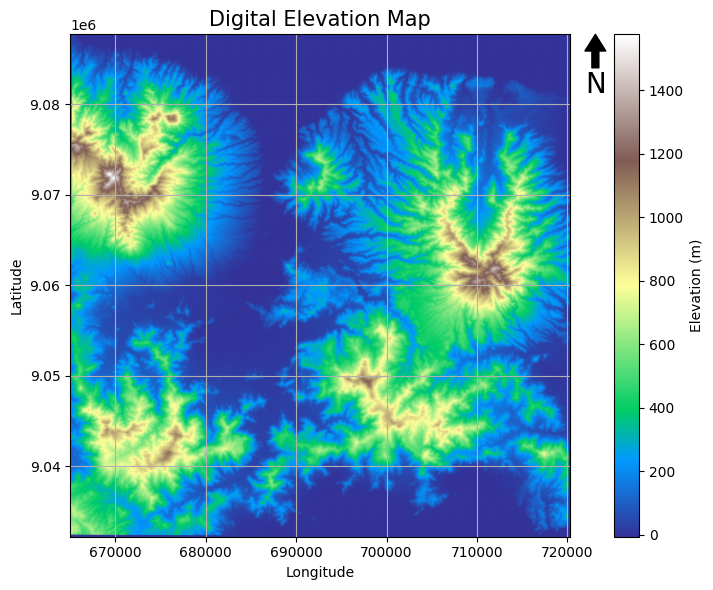

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
fig, ax = plt.subplots (figsize=(9,6))
fig.patch.set_alpha(0)
x, y, arrow_length = 1.05, 1, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
arrowprops=dict(facecolor='black', width=5, headwidth=15),
ha='center', va='center', fontsize=20,
xycoords=ax.transAxes)
plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital Elevation Map', size=15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [15]:
pit_filled_dem = grid.fill_pits(dem)
flooded_dem = grid.fill_depressions(pit_filled_dem)
inflated_dem = grid.resolve_flats(flooded_dem)

In [19]:
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

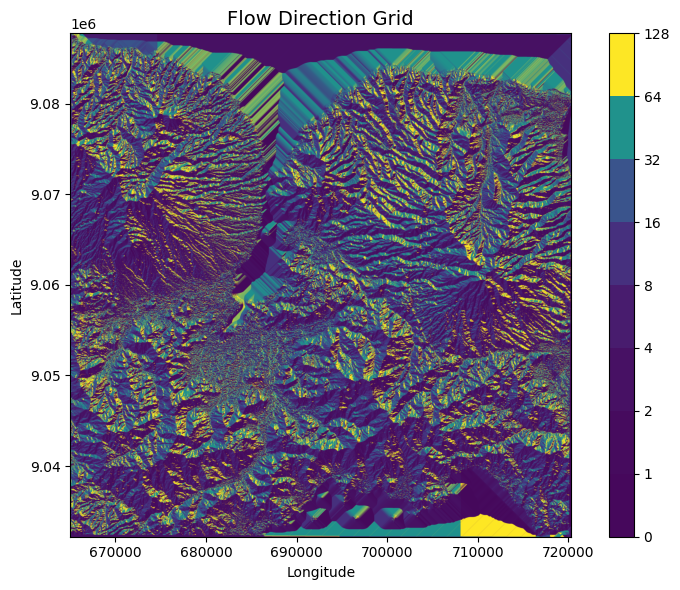

In [21]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)
plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries=boundaries,
values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Direction Grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

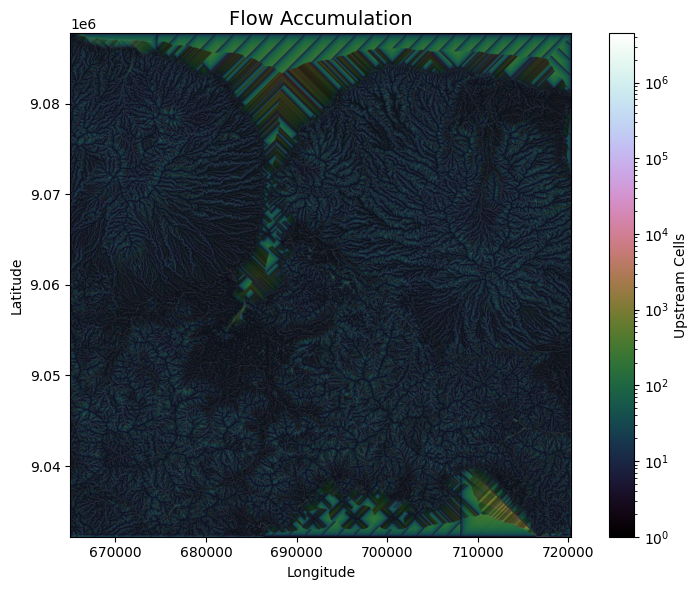

In [23]:
acc = grid.accumulation(fdir, dirmap=dirmap)
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,cmap="cubehelix", norm=colors.LogNorm(1, acc.max()),
interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

Text(0.5, 1.0, 'Delineated Catchment')

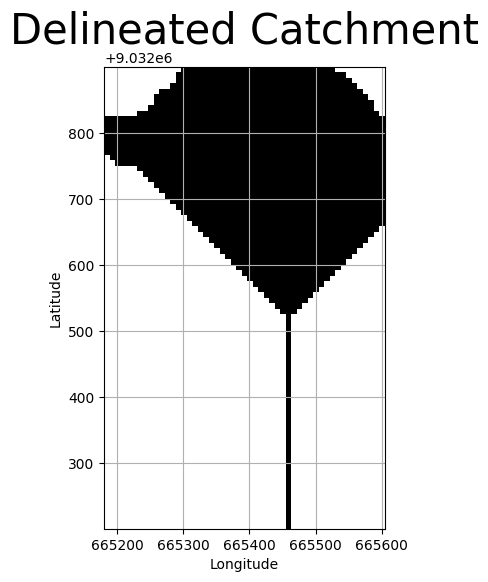

In [31]:
x, y = 118.718653, -8.441884
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')
grid.clip_to(catch)
clipped_catch = grid.view(catch)
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent, zorder=1, cmap='Greys_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=30)

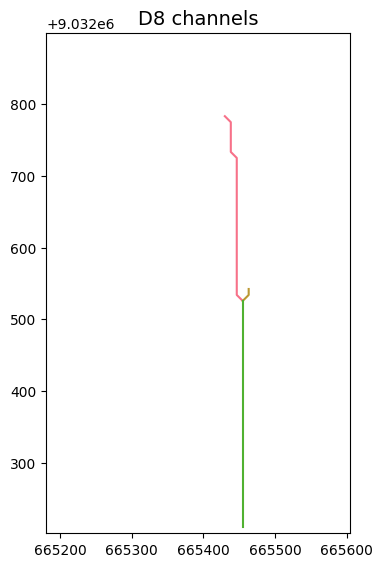

In [37]:
branches = grid.extract_river_network(fdir, acc > 400, dirmap=dirmap)
sns.set_palette('husl')
fig, ax = plt.subplots (figsize=(8.5,6.5))
plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox [1], grid.bbox[3])
ax.set_aspect('equal')
for branch in branches['features']:
    line = np.asarray (branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
_ = plt.title('D8 channels', size=14)

In [45]:
from osgeo import gdal, ogr
import sys
import os
gdal.UseExceptions()
fileName = "/content/clipped_catchment.tif" # Use the path to the saved raster file
src_ds = gdal.Open(fileName)
if src_ds is None:
    print('Unable to open %s' % fileName) # Use fileName here
    sys.exit(1)
srcband = src_ds.GetRasterBand(1)
dst_layername = "Polyftr"
drv = ogr.GetDriverByName("ESRI Shapefile")
dst_ds = drv.CreateDataSource(dst_layername + ".shp")
dst_layer = dst_ds.CreateLayer(dst_layername, srs=None)
newField = ogr.FieldDefn('Area', ogr.OFTInteger)
dst_layer.CreateField(newField)
gdal.Polygonize(srcband, None, dst_layer, 0, [],
               callback=None)

# Close the datasets
dst_ds = None
src_ds = None

print(f"Clipped catchment polygonized and saved as {dst_layername}.shp")

Clipped catchment polygonized and saved as Polyftr.shp


In [43]:
from osgeo import gdal
import numpy as np

# Define output file path
output_raster_path = "/content/clipped_catchment.tif"

# Get spatial information from the original DEM grid
geotransform = grid.affine.to_gdal()
projection = grid.crs.to_wkt()

# Get the dimensions of the clipped_catch array
rows_clipped, cols_clipped = clipped_catch.shape

# Get the data type of the clipped_catch array
dtype = clipped_catch.dtype

# Create a new GeoTIFF file using the clipped array dimensions
driver = gdal.GetDriverByName("GTiff")
out_raster = driver.Create(output_raster_path, cols_clipped, rows_clipped, 1, gdal.GDT_Float32)

# Set the geotransform and projection
out_raster.SetGeoTransform(geotransform)
out_raster.SetProjection(projection)

# Write the clipped_catch array to the raster band
out_band = out_raster.GetRasterBand(1)
out_band.WriteArray(clipped_catch)

# Set the NoData value if applicable (assuming NaN in clipped_catch represents NoData)
if np.isnan(np.min(clipped_catch)):
    out_band.SetNoDataValue(np.nan)

# Clear the cache and close the dataset
out_band.FlushCache()
out_raster = None

print(f"Clipped catchment saved as {output_raster_path}")

Clipped catchment saved as /content/clipped_catchment.tif
